<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Unifying_Grokking_and_Double_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### モデルの構成

#### 1. **予測関数**

各モデルの予測値は以下のシグモイド関数によって計算される：

\\
$
\displaystyle
\text{pred}_i(p_i, t) = \frac{p_i["\gamma"]}{1 + \exp(-p_i["\alpha"] \cdot (t - p_i["b"]))}
$


ここで，パラメータ $ p_i $ は次の通り：
- $ \gamma $ : シグモイド関数の最大値
- $ \alpha $ : 勾配の鋭さ（シグモイド関数の傾き）
- $ b $ : シグモイド関数の中心位置
- $ t $ : 時間またはエポック数

\\
#### 2. **訓練精度の計算**

訓練精度は以下の式で計算される：

$
\displaystyle
\text{acc}(p_1, p_2, p_3, t) = \text{pred}_1(p_1, t) + \text{pred}_2(p_2, t) + \text{pred}_3(p_3, t) - (\text{pred}_1(p_1, t) \cdot \text{pred}_2(p_2, t) + \text{pred}_1(p_1, t) \cdot \text{pred}_3(p_3, t) + \text{pred}_2(p_2, t) \cdot \text{pred}_3(p_3, t)) + \text{pred}_1(p_1, t) \cdot \text{pred}_2(p_2, t) \cdot \text{pred}_3(p_3, t)
$

モデルの出力の合計から，ペアごとの積を引き，3つのモデルの出力の積を加えたもの．

\\
#### 3. **テスト精度の計算**

テスト精度は以下の式で計算される：

$
\text{gen}(p_1, p_2, p_3, t) = u_1 \cdot p_1["g"] + u_2 \cdot p_2["g"] + u_3 \cdot p_3["g"]
$

ここで，$ u_1 $, $ u_2 $, $ u_3 $ は以下のように定義される：

$
\begin{aligned}
u_1 &= \text{pred}_1(p_1, t) - \text{pred}_3(p_3, t) \cdot \text{pred}_1(p_1, t) - \frac{\text{pred}_1(p_1, t) \cdot \text{pred}_2(p_2, t)}{2} + \frac{\text{pred}_1(p_1, t) \cdot \text{pred}_2(p_2, t) \cdot \text{pred}_3(p_3, t)}{2} \\
u_2 &= \text{pred}_2(p_2, t) - \text{pred}_3(p_3, t) \cdot \text{pred}_2(p_2, t) - \frac{\text{pred}_1(p_1, t) \cdot \text{pred}_2(p_2, t)}{2} + \frac{\text{pred}_1(p_1, t) \cdot \text{pred}_2(p_2, t) \cdot \text{pred}_3(p_3, t)}{2} \\
u_3 &= \text{pred}_3(p_3, t)
\end{aligned}
$

ここで，パラメータ $ p_i["g"] $ は，モデル $ p_i $ のテスト精度への寄与度を示す．

\\
### 実験の目的と可視化

#### 1. **Double Descent**

**Double Descent** の現象をモデル化するために，以下のような設定が行われる：

- **学習パターン**:
  - 各モデルの予測値 $ \text{pred}_i(p_i, t) $ をエポック数 $ t $ に対してプロットする．

- **精度**:
  - 訓練精度とテスト精度をエポック数 $ t $ に対してプロットする．Double Descent 現象は，訓練精度が向上する一方でテスト精度が一度低下し，その後再び向上することを示す．

#### 2. **Grokking**

**Grokking** の現象をモデル化するためには，以下の設定が行われる：

- **学習パターン**:
  - $ p_1["\gamma"] = 0 $ および $ p_3["\gamma"] = 1 $ に設定して，Grokking の条件を設定する．

- **精度**:
  - 訓練精度とテスト精度をエポック数 $ t $ に対してプロットする．Grokking の場合，長期間の訓練後に急激な精度の向上が観察されることが期待される．

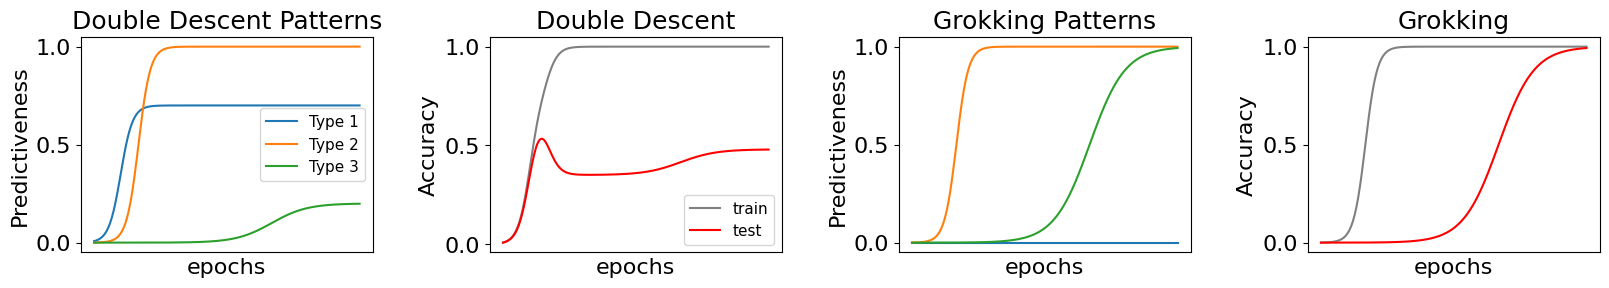

In [3]:
import torch
import matplotlib.pyplot as plt

# 学習パターンのモデル化関数
def pred_i(p, t):
    return p["gamma"] / (1 + torch.exp(-p["alpha"] * (t - p["b"])))

# 訓練精度の計算関数
def acc(p_1, p_2, p_3, t):
    preds = torch.stack([pred_i(p_1, t), pred_i(p_2, t), pred_i(p_3, t)])
    return preds.sum(0) - (preds[0] * preds[1] + preds[0] * preds[2] + preds[1] * preds[2]) + preds[0] * preds[1] * preds[2]

# テスト精度の計算関数
def gen(p_1, p_2, p_3, t):
    preds = torch.stack([pred_i(p_1, t), pred_i(p_2, t), pred_i(p_3, t)])
    u_1 = preds[0] - preds[2] * preds[0] - preds[0] * preds[1] / 2 + preds[0] * preds[1] * preds[2] / 2
    u_2 = preds[1] - preds[2] * preds[1] - preds[0] * preds[1] / 2 + preds[0] * preds[1] * preds[2] / 2
    u_3 = preds[2]
    return u_1 * p_1["g"] + u_2 * p_2["g"] + u_3 * p_3["g"]

# Double Descent と Grokking のモデル化パラメータ
STEPS = 300
t = torch.arange(0, STEPS).float()

p_1 = {
    "gamma": 0.7,
    "alpha": 0.15,
    "b": 30,
    "g": 1,
}

p_2 = {
    "gamma": 1.0,
    "alpha": 0.15,
    "b": 50,
    "g": 0,
}

p_3 = {
    "gamma": 0.2,
    "alpha": 0.05,
    "b": 200,
    "g": 1,
}


# plot
fig, axs = plt.subplots(1, 4, figsize=(28*0.7, 4*0.7))
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE + 1)
plt.rc('axes', titlesize=SMALL_SIZE + 3)
plt.rc('legend', fontsize=SMALL_SIZE - 4)

# Double Descent の学習パターン
axs[0].plot(t.numpy(), pred_i(p_1, t).numpy(), label="Type 1")
axs[0].plot(t.numpy(), pred_i(p_2, t).numpy(), label="Type 2")
axs[0].plot(t.numpy(), pred_i(p_3, t).numpy(), label="Type 3")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("Predictiveness")
axs[0].legend()
axs[0].set_xticks([])
axs[0].set_title("Double Descent Patterns")

# Double Descent の精度
axs[1].plot(t.numpy(), acc(p_1, p_2, p_3, t).numpy(), label="train", color="gray")
axs[1].plot(t.numpy(), gen(p_1, p_2, p_3, t).numpy(), label="test", color="red")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epochs")
axs[1].set_xticks([])
axs[1].set_title("Double Descent")
axs[1].legend()

# Grokking の学習パターン
p_1["gamma"] = 0.0
p_3["gamma"] = 1.0

axs[2].plot(t.numpy(), pred_i(p_1, t).numpy(), label="Type 1")
axs[2].plot(t.numpy(), pred_i(p_2, t).numpy(), label="Type 2")
axs[2].plot(t.numpy(), pred_i(p_3, t).numpy(), label="Type 3")
axs[2].set_ylabel("Predictiveness")
axs[2].set_xlabel("epochs")
axs[2].set_xticks([])
axs[2].set_title("Grokking Patterns")

# Grokking の精度
axs[3].plot(t.numpy(), acc(p_1, p_2, p_3, t).numpy(), label="train", color="gray")
axs[3].plot(t.numpy(), gen(p_1, p_2, p_3, t).numpy(), label="test", color="red")
axs[3].set_ylabel("Accuracy")
axs[3].set_xlabel("epochs")
axs[3].set_xticks([])
axs[3].set_title("Grokking")

plt.subplots_adjust(wspace=0.4)
plt.savefig("toy_model_pytorch.pdf")